#### - Sobhan Moradian Daghigh
#### - 12/29/2021
#### - PR - EX02 - Q6 - Part I

In [1]:
import numpy as np
from PIL import Image, ImageCms
import os, io
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import colour
import cv2

In [2]:
def get_data_paths(directory):
    filePaths = []
    for dirpath,_,filenames in os.walk(directory):
        for image_name in filenames:
            filePaths.append(os.path.abspath(os.path.join(dirpath, image_name))) 
    return filePaths

In [3]:
train1 = get_data_paths("./inputs/P6/pratheepan/train/set1/images")
train2 = get_data_paths("./inputs/P6/pratheepan/train/set2/images")
train = train1 + train2
train_masks1 = get_data_paths("./inputs/P6/pratheepan/train/set1/groundtruth")
train_masks2 = get_data_paths("./inputs/P6/pratheepan/train/set2/groundtruth")
train_masks = train_masks1 + train_masks2

### Part A.
#### Prior Probability

In [4]:
skinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]
noskinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]

# For next step, calculating the mean and covariance matrix
skin_list = []
noSkin_list = []

for i in range(len(train)):
    img = Image.open(train[i]).convert('RGB')
    mask = Image.open(train_masks[i]).convert('RGB')
    w, h = img.size
    
    for j in range(h):
        for i in range(w):
            red, green, blue = img.getpixel((i, j))
            maskRed, maskGreen, maskBlue = mask.getpixel((i, j))

            if(maskRed > 150 and maskGreen > 150 and maskBlue > 150):
                skinPixelCounts[red][green][blue] += 1
                skin_list.append([red, green, blue])
            else:
                noskinPixelCounts[red][green][blue] += 1
                noSkin_list.append([red, green, blue])
                
                
    img.close()
    mask.close()

In [5]:
def nested_sum(L):
    total = 0
    for i in L:
        if isinstance(i, list):
            total += nested_sum(i)
        else:
            total += i
    return total

In [6]:
# Skin Pixels Frequency
skin_count = nested_sum(skinPixelCounts)

In [7]:
# NoSkin Pixels Frequency
noSkin_count = nested_sum(noskinPixelCounts)

In [8]:
# Sum of pixels
pix_count = np.add(skin_count, noSkin_count)

#### Skin Prior Probability

In [9]:
skin_prior = round(np.divide(skin_count, pix_count), 3)
print(skin_prior)

0.17


#### NoSkin Prior Probability

In [10]:
noSkin_prior = round(np.divide(noSkin_count, pix_count), 3)
print(noSkin_prior)

0.83


### Part B.
#### Mean-Variance

In [11]:
def get_meanCov(datas):
    mean = np.divide([sum(x) for x in zip(*datas)], len(datas))
    # The dimention is too high, so Im not wanna calculate in matrix form
    # cov = np.matmul([np.subtract(x, mean) for x in datas], np.transpose([np.subtract(x, mean) for x in datas]))
    temp = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for ele in datas:
        sub = np.subtract(ele, mean).reshape(3, 1)
        temp = np.add(temp, np.matmul(np.array(sub), np.transpose(np.array(sub))))
    cov = np.divide(temp, len(datas))
    return mean, cov

#### Skin Mean and Covariance

In [12]:
skin_mean, skin_cov = get_meanCov(skin_list)
print("Mean: \n{}".format(skin_mean))
print("\nCovariance: \n{}".format(skin_cov))

Mean: 
[ 173.69143703  126.67701085  103.72783878]

Covariance: 
[[ 2546.43790058  2283.09177803  2037.45442684]
 [ 2283.09177803  2405.13276832  2305.30822235]
 [ 2037.45442684  2305.30822235  2400.91068099]]


In [13]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(skin_cov)

119702431.51445019

#### NoSkin Mean and Covariance

In [14]:
noSkin_mean, noSkin_cov = get_meanCov(noSkin_list)
print("Mean: \n{}".format(noSkin_mean))
print("\nCovariance: \n{}".format(noSkin_cov))

Mean: 
[ 118.23202621  103.54506664   97.25827234]

Covariance: 
[[ 6283.85028637  5366.67769867  4909.83720452]
 [ 5366.67769867  5749.0138401   5463.80554492]
 [ 4909.83720452  5463.80554492  5826.84169721]]


In [15]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(noSkin_cov)

4435713789.7784777

### Part C.
#### Classify Trump-Putin

In [16]:
# Continues with Noraml Distribution
def cal_probability_density(mean, cov, x):
    var = multivariate_normal(mean=mean, cov=cov)
    prob = var.pdf(x)
    return prob

In [17]:
def BC(skin_liklihood, noSkin_liklihood, blank, thresh=0.0):
    predictions = []
    thresh = 0.1 if thresh == 0 else thresh
    skin_posterior = np.add(np.add(np.log(skin_liklihood), np.log(skin_prior)), np.log2((thresh * 10)))

    noSkin_posterior = np.add(np.log(noSkin_liklihood), np.log(noSkin_prior))

    sub = np.array(np.subtract(skin_posterior, noSkin_posterior))
    
    for j in range(sub.shape[1]):
        for i in range(sub.shape[0]):
            blank[i][j] = [0, 0, 0] if sub[i][j] < 0 else [255, 255, 255]
        
    return blank

In [18]:
def skinDetection(img_name, thresh=0.0):
    
    img = Image.open(img_name).convert('RGB')
    w, h = img.size
    blank = np.zeros((h, w, 3), dtype=int)

    skin_liklihood = cal_probability_density(skin_mean, skin_cov, np.array(img))
    noSkin_liklihood = cal_probability_density(noSkin_mean, noSkin_cov, np.array(img))
    blank = BC(skin_liklihood, noSkin_liklihood, blank, thresh)

    return blank

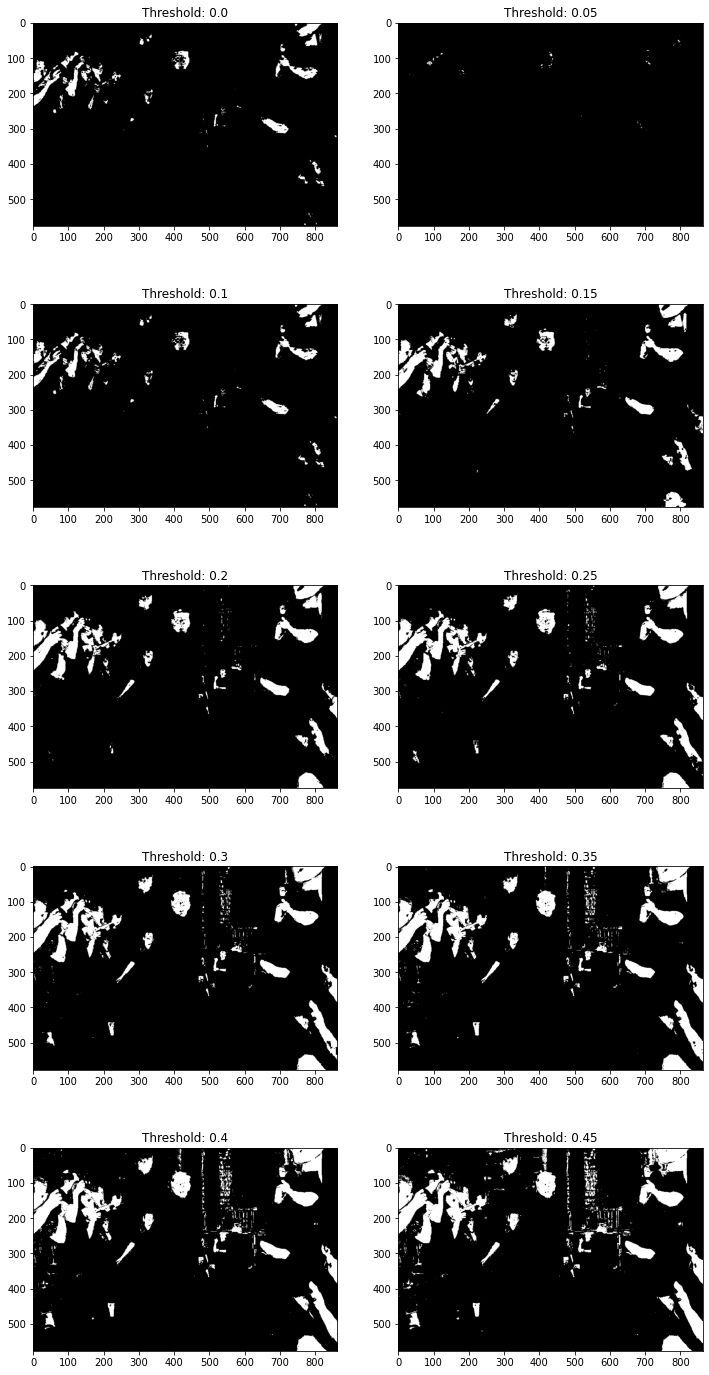

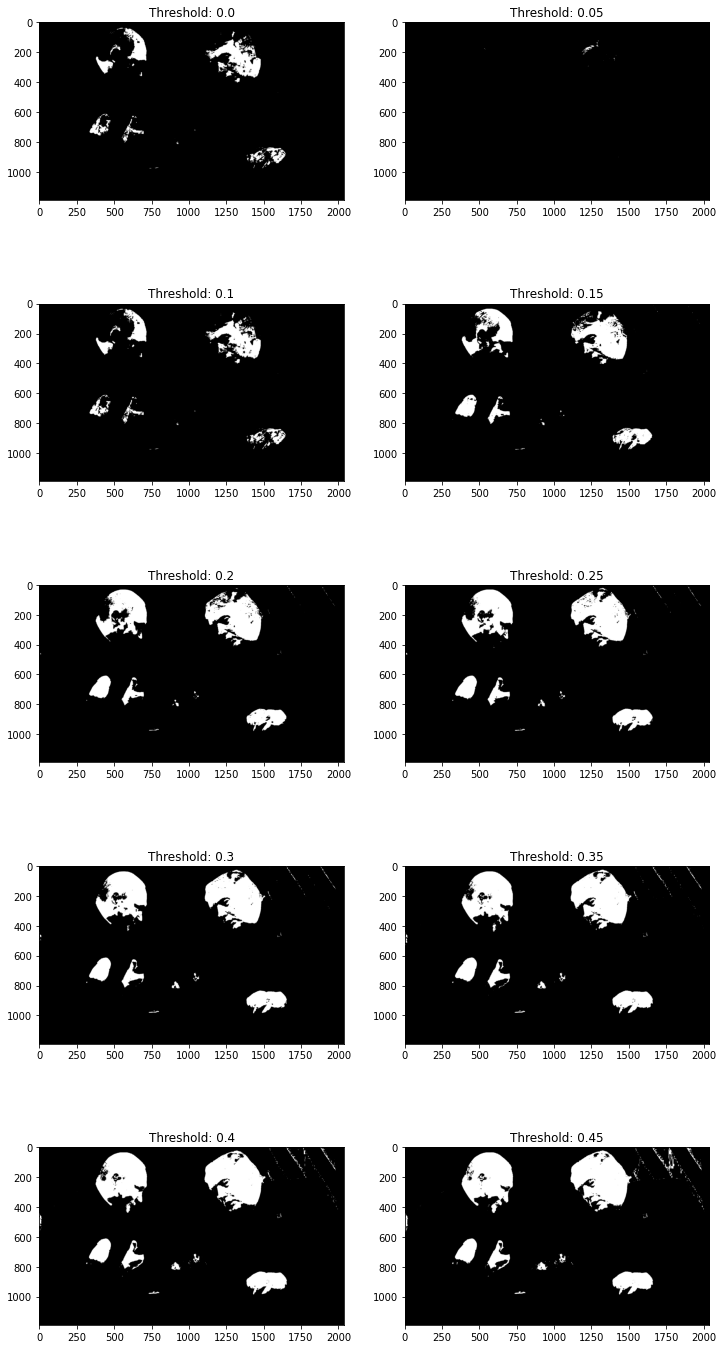

In [19]:
images = ['trump_tie_2.jpg', 'trump_tie_1.jpg']

for i in range(2):
    fig, ax = plt.subplots(5, 2, figsize=(12, 25))
    img_name = './inputs/P6/{}'.format(images[i])
    idx = 0
    for thresh in np.arange(0.0, 0.5, 0.05):
        thresh = round(thresh, 2)
        blank = skinDetection(img_name, thresh)
        ax[np.divmod(idx, 2)[0], np.divmod(idx, 2)[1]].imshow(blank, cmap='gray')
        ax[np.divmod(idx, 2)[0], np.divmod(idx, 2)[1]].set_title('Threshold: {}'.format(thresh))
        idx += 1

    plt.show()

### Part D.
#### MDC

In [20]:
skin_prototype = skin_mean
noSkin_prototype = noSkin_mean

In [21]:
def display_prototype(prototype):
    print("Skin prototype:")
    img = np.zeros([20,20,3],dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j] = prototype
    plot = plt.figure()
    plt.imshow(img)
    plt.show()

Skin prototype:


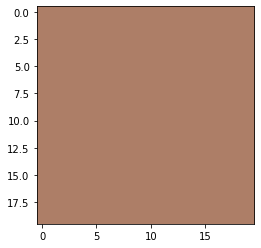

In [22]:
display_prototype(skin_prototype)

Skin prototype:


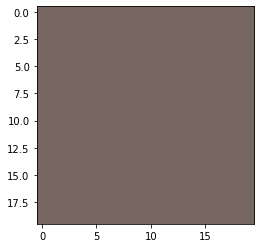

In [38]:
display_prototype(noSkin_prototype)

In [23]:
def cal_distance(img_name, prototypes):
    distances = []
    img = Image.open('./inputs/P6/{}'.format(img_name))
    w, h = img.size
    
    for proto in prototypes:
        mean = np.zeros([h, w, 3],dtype=np.uint8)
        for i in range(mean.shape[0]):
            for j in range(mean.shape[1]):
                mean[i][j] = proto

# ------- To have a perceptually uniform color space, we can convert RGB to Lab --------
#         mean_lab = cv2.cvtColor(mean.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)
#         img_lab = cv2.cvtColor(img.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)
#         delta_E = colour.delta_E(img_lab, mean_lab)
# --------------------------------------------------------------------------------------

        dis = np.linalg.norm(img - mean, axis=2)
        distances.append(dis)
        
    return distances, h, w

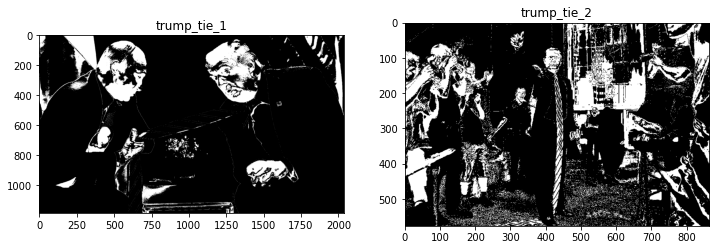

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 50))
images = ['trump_tie_1.jpg', 'trump_tie_2.jpg']

for k in range(2):
    distances, h, w = cal_distance(images[k], [skin_prototype, noSkin_prototype])
    blank = np.zeros((h, w, 3), dtype=int)
    for j in range(0, h):
        for i in range(0, w):
            idx = np.argmin([distances[0][j][i] + 45, distances[1][j][i]])
            blank[j][i] = [0, 0, 0] if idx == 1 else [255, 255, 255]
            
    ax[k].imshow(blank, cmap='gray')
    ax[k].set_title('{}'.format(images[k].split('.')[0]))

### Part E.
#### Classify Test pixels

In [31]:
test = get_data_paths("./inputs/P6/pratheepan/test/images")
test_masks = get_data_paths("./inputs/P6/pratheepan/test/groundtruth")

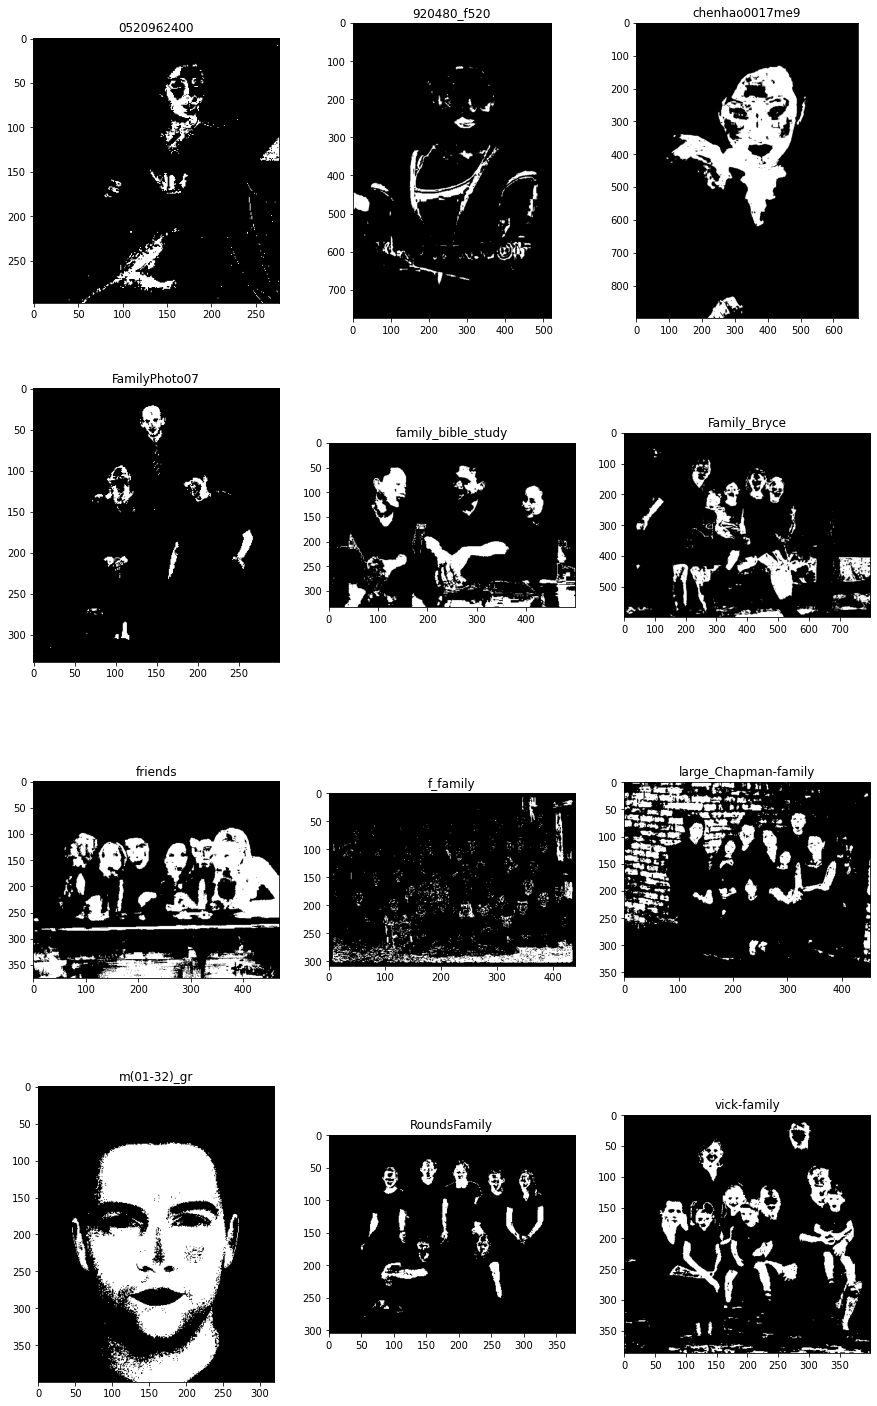

In [40]:
fig, ax = plt.subplots(4, 3, figsize=(15, 25))
predicted_images = []
for i in range(len(test)):
    img_name = test[i]
    blank = skinDetection(img_name)
    ax[np.divmod(i, 3)[0], np.divmod(i, 3)[1]].imshow(blank, cmap='gray')
    ax[np.divmod(i, 3)[0], np.divmod(i, 3)[1]].set_title('{}'.format(img_name.split('\\')[-1].split('.')[0]))
    predicted_images.append(blank)
plt.show()

In [41]:
def evaluate(predicted_images):
    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(predicted_images)):
        mask = Image.open(test_masks[i]).convert('RGB')
        mask = np.array(mask)
        pred = predicted_images[i]
        
        w, h, _ = mask.shape
        
        sub = np.subtract(np.array(mask), np.array(pred))
        sum_ = np.add(np.array(mask), np.array(pred))
        
        sub_brief = np.sum(sub, axis=2)
        sum_brief = np.sum(sum_, axis=2)
        
        for i in range(-50, 50):
        
            FP += np.count_nonzero(sub_brief == -765 + i)
            FN += np.count_nonzero(sub_brief == 765 + i)

            TP += np.count_nonzero(sum_brief == 1530 + i)
            TN += np.count_nonzero(sum_brief == 0 + i)
   
    T = np.add(TP, TN)
    F = np.add(FP, FN)
    accuracy = np.divide(T, np.add(T, F))
    
    return accuracy, TP, TN, FP, FN

In [42]:
accuracy, TP, TN, FP, FN = evaluate(predicted_images)
print(round(accuracy, 3))

0.886


### Part F.
#### Confusion Matrix

In [43]:
print("TP: {}\tFN:{}\nFP: {}\tTN: {}".format(TP, FN, FP, TN))

TP: 214977	FN:208658
FP: 99306	TN: 2190219


### Part H.
#### ROC

In [36]:
def cal_PRates(TP, FP, FN, TN):
    TPR = np.divide(TP, np.add(TP, FN))
    FPR = np.divide(FP, np.add(FP, TN))
    return TPR, FPR

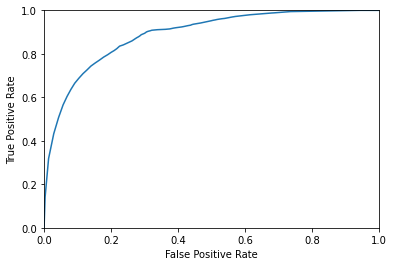

In [37]:
TPR_rates = []
FPR_rates = []
range_ = np.concatenate([np.arange(0.01, 5, 0.015), np.arange(10, 1000000, 10000), [np.infty]])

for thresh in range_:
    predicted_images = []
    for i in range(len(test)):
        img_name = test[i]
        blank = skinDetection(img_name, thresh)
        predicted_images.append(blank)
        
    _, TP, TN, FP, FN = evaluate(predicted_images)
    TPR, FPR = cal_PRates(TP, FP, FN, TN)
    TPR_rates.append(TPR)
    FPR_rates.append(FPR)
    
    
# plt.plot(FPR_rates, TPR_rates, linestyle='--', label='No Skill')
plt.plot(FPR_rates, TPR_rates)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()